In [1]:
import os

# This guide can only be run with the torch backend.
os.environ["KERAS_BACKEND"] = "torch"

import torch
import keras_core as keras
from keras_core import layers
import numpy as np

Using PyTorch backend.


In [5]:
discriminator = keras.Sequential([
keras.Input(shape=(28,28,1)),
layers.Conv2D(64,(3,3),strides=(2,2),padding="same"),
layers.LeakyReLU(negative_slope=0.2),
layers.Conv2D(128,(3,3),strides=(2,2),padding="same"),
layers.LeakyReLU(negative_slope=0.2),  
layers.GlobalMaxPooling2D(),
layers.Dense(1)]
    ,name="discriminator")

In [8]:
latent_dim = 128
generator = keras.Sequential([
keras.Input(shape=(latent_dim,)),
layers.Dense((7*7*128)),
layers.LeakyReLU(negative_slope=0.2),
layers.Reshape((7,7,128)),
layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
layers.LeakyReLU(negative_slope=0.2),
layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"),
layers.LeakyReLU(negative_slope=0.2),  
layers.Conv2D(1,(7,7),padding="same",activation="sigmoid"),
],name="generator")

In [25]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.built = True

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = real_images.shape[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_latent_vectors = random_latent_vectors.cuda()

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        real_images = torch.tensor(real_images).cuda()
        
        combined_images = torch.concat([generated_images,real_images],axis=0).cuda()
        # Assemble labels discriminating real from fake images
        labels = torch.concat([torch.ones((batch_size,1)),torch.zeros((batch_size,1))],axis=0).cuda()
        # Add random noise to the labels - important trick!
        labels += 0.05 * keras.random.uniform(labels.shape, seed=self.seed_generator)
        labels = labels.cuda()
        # Train the discriminator
        self.zero_grad()
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels,predictions)
        d_loss.backward()
        
        grads = [v.value.grad for v in self.discriminator.trainable_weights]
        with torch.no_grad():
            self.d_optimizer.apply(grads, self.discriminator.trainable_weights)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_latent_vectors = random_latent_vectors.cuda()

        # Assemble labels that say "all real images"
        misleading_labels = torch.zeros((batch_size,1)).cuda()

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        self.zero_grad()
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels,predictions)
        grads = g_loss.backward()
        grads = [v.value.grad for v in self.generator.trainable_weights]
        with torch.no_grad():
            self.g_optimizer.apply(grads,self.generator.trainable_weights)

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [39]:
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

# Create a TensorDataset
dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(all_digits), torch.from_numpy(all_digits)
)
# Create a DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(dataloader, epochs=10)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.2982 - g_loss: 2.1764
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5005 - g_loss: 1.5703
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.6365 - g_loss: 0.9634
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.6220 - g_loss: 0.9505
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5950 - g_loss: 1.0398
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5871 - g_loss: 1.0317
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5867 - g_loss: 1.0316
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5806 - g_loss: 1.0302
Epoch 9/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5728 - g_loss: 1.0497
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - d_loss: 0.5766 - g_loss: 1.0640


In [40]:
random_latent_vectors_i = keras.random.normal(
            shape=(batch_size, 128), seed=keras.random.SeedGenerator(1337)
)
random_latent_vectors_i = random_latent_vectors_i.cuda()
pred = gan.generator(random_latent_vectors_i)

In [33]:
import matplotlib.pyplot as plt

In [55]:
pred_0 = pred[8]

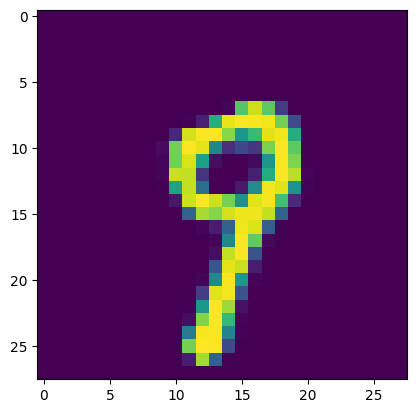

In [56]:
plt.imshow(pred_0.cpu().detach().numpy())

In [58]:
import torch.nn as nn

In [59]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = gan.generator

    def forward(self, x):
        return self.model(x)

In [60]:
torch_module = MyModel()

In [73]:
torch.save(torch_module.state_dict(),"generator_torch.pt")

In [74]:
torch_module_state_dict = torch.load("generator_torch.pt")

In [75]:
new_module = MyModel()

In [76]:
new_module.load_state_dict(torch_module_state_dict)

<All keys matched successfully>

In [80]:
pred_loaded_model = new_module(random_latent_vectors_i)

In [81]:
pred_loaded = pred_loaded_model[8]

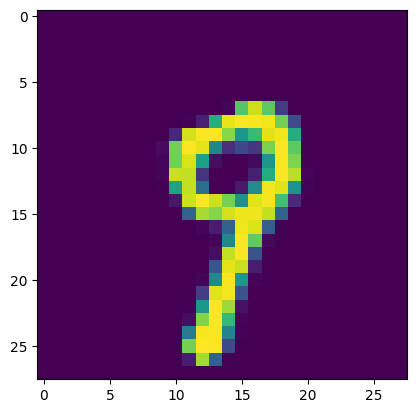

In [82]:
plt.imshow(pred_loaded.cpu().detach().numpy())